# Advanced dimensionality reduction methods
This tutorial will provide a high-level overview of some of the more advanced techniques for dimensionality reduction. We will be using the [handwritten digits data set](http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits), which is a collection of images of handwritten digits between 0 and 9. The data was generated by a total of 43 people, who wrote a total of 5620 digits by hand which were then digitized and processed into 8x8 greyscale images.

**Please note**: most of the code has been taken directly from [this example code](https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html#), which contains a few other examples of dimensionality reduction techniques, in addition to those expanded on here.

In [21]:
from time import time
import numpy as np
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)
from matplotlib import offsetbox
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (15,10)})

## Loading and inspecting the data
The digits data set is included as part of the sk-learn library, which makes loading it into our notebook a breeze. For this tutorial, we will simplify things by only looking at the first 6 digits in the data set. We can use the `n_class` argument in the `load_digits()` function to select only the numbers from 0 to 5.

In [22]:
digits = datasets.load_digits(n_class=6)
X = digits.data
y = digits.target
n_samples, n_features = X.shape

In [23]:
print("Total number of samples: ", n_samples)
print("Features per sample: ", n_features)

Total number of samples:  1083
Features per sample:  64


### Images as data   
In the image below, the image on the left can be represented as a 14x14 array of pixels, with values ranging between 0 (white) and 1 (black).   

![mnist-array](https://tensorflow.rstudio.com/tensorflow/articles/images/MNIST-Matrix.png)   
(Source [: TensorFlow for R](https://tensorflow.rstudio.com/tensorflow/articles/tutorial_mnist_beginners.html))   

The same concept applies to our data set, only the arrays are a little smaller (8x8) and they have been strung out into single rows of 64 values, ranging between 0 and 16. Let's take a look at the first digit in the data:

In [24]:
X[0,:]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

In [25]:
# what digit is this?
y[0]

0

## Plotting the data
Could you tell that the first array was a zero? Unless you are some sort of savant genius, you probably weren't be able to tell which digit is represented by the array above.   

Luckily, we can use the `imshow()` function from the matplotlib library to plot these digits:

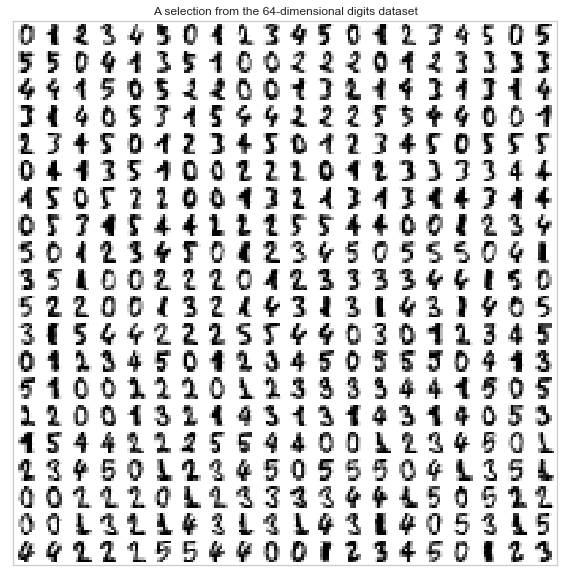

In [26]:
# Plot images of the digits
n_img_per_row = 20

# create a large grid of zeros
img = np.zeros((10 * n_img_per_row, 10 * n_img_per_row))

# for each column
for i in range(n_img_per_row):
    
    # find the x-coordinate
    ix = 10 * i + 1
    
    # for each row 
    for j in range(n_img_per_row):
        
        # find the y-coordiante
        iy = 10 * j + 1
        
        # change the pixels in this part of the grid to match the digit
        img[ix:ix + 8, iy:iy + 8] = X[i * n_img_per_row + j].reshape((8, 8))

# plt the grid as a single image
plt.imshow(img, cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.title('A selection from the 64-dimensional digits dataset')
plt.show()

## Dimensionality reduction
Now, what we are going to try and do is reduce the dimensionality of the entire data set to just two dimensions. We will use a few different dimensionality reduction techniques, and at each stage we will plot the data and see how it is distributed in these two dimensions.   

What is very important to note here is that none of these algorithms will be shown the labels of the data; they will be entirely unsupervised. In each case, we will plot the data in two dimensions, but include the known labels of the data points in the plots for our own validation.   

For plotting, we are going to use the same `plot_embedding()` function defined in the original Sk-learn example code. This does a fantastic job of plotting the digits in two-dimensional space, so there is no need to reinvent the wheel here.   

NOTE: You will see the word **"embedding"** used in some of the comments and plots below. Simply put, an embedding is a representation of a vector in a different feature space. So in this case, the original digits exist as 64-dimensional arrays and are then reduced to just 2 dimensions. The resulting 2-dimensional vectors are reffered to as the embedding vectors.

In [27]:
# Scale and visualize the embedding vectors
def plot_embedding(X, title=None):
    
    # normalise data
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    
    ax = plt.subplot(111)
    
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

### Principal Component Analysis (PCA)
PCA was covered in a previous tutorial, so we won't go into great detail about it here. We know that the objective of PCA is to decompose a data set into mutually orthogonal components, that best maintain the total variance in the data set.   

We will use PCA to decompose the data set into the first two principal components, which will contain the largest and second largest amounts of variance, respectively.

In [31]:
print("Computing PCA projection")
t0 = time()
X_pca = decomposition.PCA(n_components=2).fit_transform(X)

Computing PCA projection


Now, before using the awesome `plot_embedding()` function, let's plot the data, without labels, in the first two principal components.

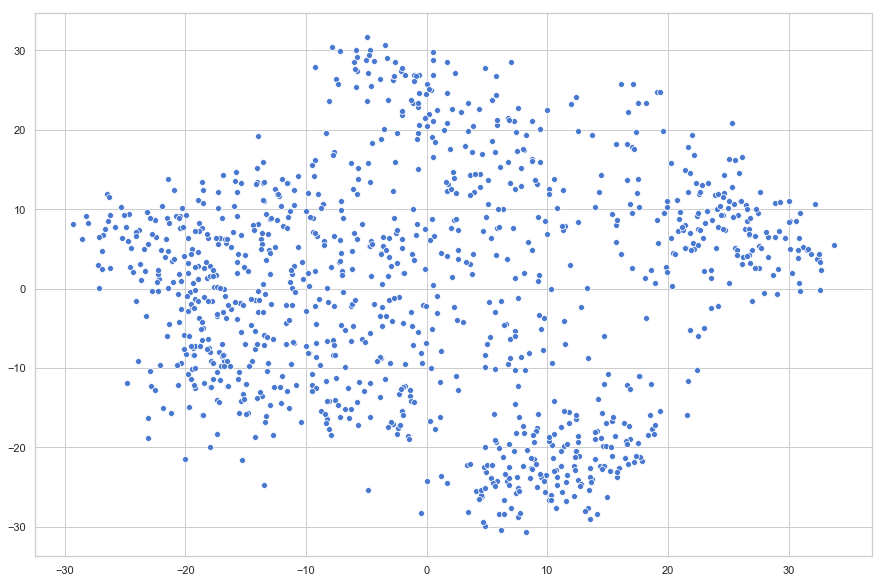

In [32]:
ax = sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1],
                     sizes=(10, 200))
plt.show()

Can you spot any obvious clusters? Perhaps one or two on the right side of the plot?   

Now, let's plot the data with labels:

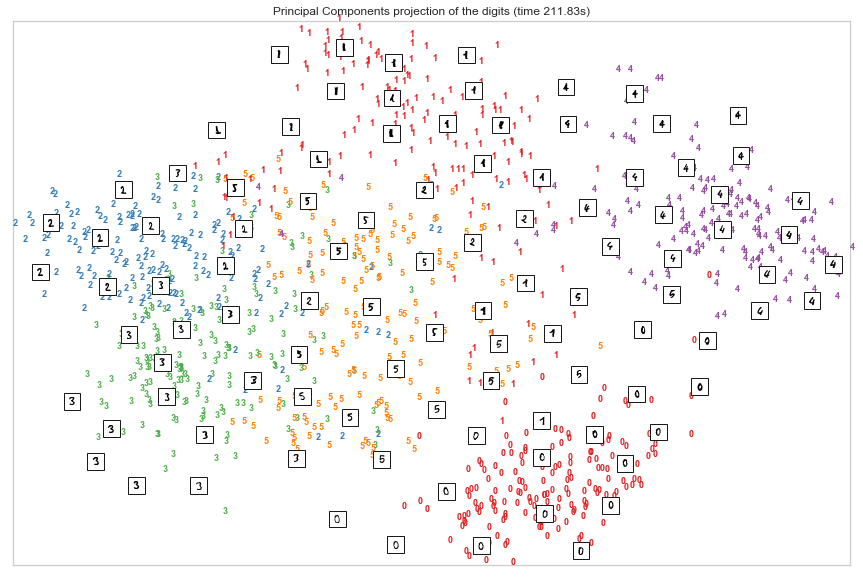

In [34]:
plot_embedding(X_pca,
               "Principal Components projection of the digits (time %.2fs)" %
               (time() - t0))
plt.show()

So we can see that digits do seem to group together, but there isn't the clearest of separation between the different digits.   

Now, let's take a look at some other techniques and see how they perform.   

### Multi-dimensional Scaling (MDS)

In [35]:
print("Computing MDS embedding")
clf = manifold.MDS(n_components=2, n_init=1, max_iter=100)
t0 = time()
X_mds = clf.fit_transform(X)
print("Done. Stress: %f" % clf.stress_)

Computing MDS embedding
Done. Stress: 142298894.227234


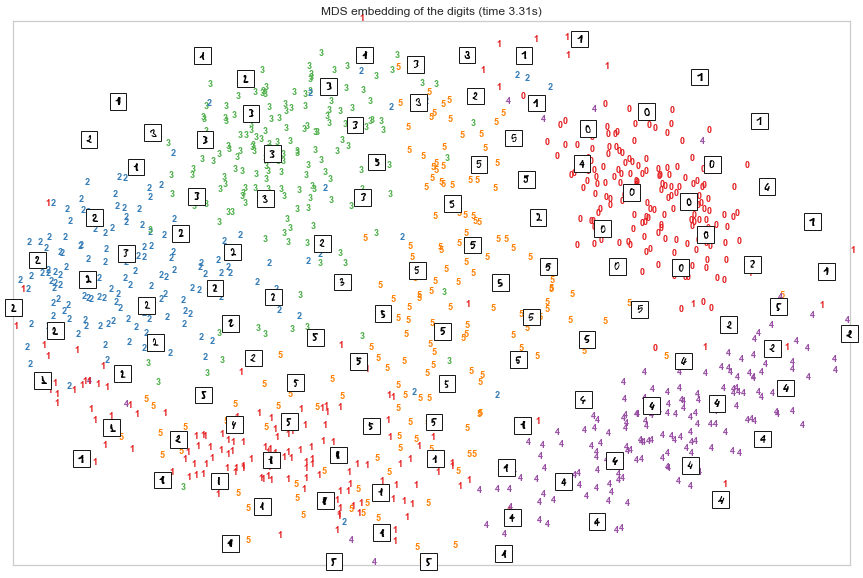

In [35]:
plot_embedding(X_mds,
               "MDS embedding of the digits (time %.2fs)" %
               (time() - t0))

### t-distributed Stochastic Neighbour Embedding (t-SNE)

Computing t-SNE embedding


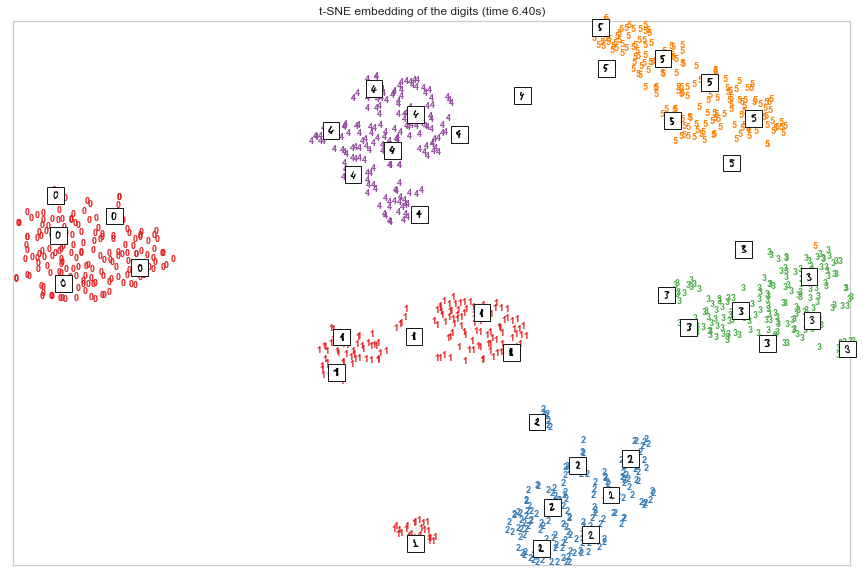

In [13]:
# t-SNE embedding of the digits dataset
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
X_tsne = tsne.fit_transform(X)

plot_embedding(X_tsne,
               "t-SNE embedding of the digits (time %.2fs)" %
               (time() - t0))

plt.show()